In [1]:
import torch
import random
import torch.nn as nn

In [1]:
import torch.distributions as D

In [2]:
import numpy as np
import cma
from tqdm.notebook import tqdm
import pickle

import matplotlib.pyplot as plt

In [3]:
import torch.nn.functional as F

In [19]:
def sample_uniform(batch_size, N_dim, r1, r2, image = False):
    random_matrix = (r1 - r2) * torch.rand([batch_size, N_dim]) + r2
    if image == False:
        return random_matrix
    else:
        side_size = int(np.sqrt(int(N_dim/3)))
        if side_size ** 2 != int(N_dim/3):
            print('N_dim/3 must be perfect square in image mode.')
            return -1
        resized = random_matrix.reshape(batch_size, 3, side_size, side_size)
        return resized

In [20]:
def get_random_mixture_model(N_dim, N_mix):
    mix = D.Categorical(torch.rand(N_dim,N_mix))
    comp = D.Independent(D.Normal(
                torch.randn(N_dim,N_mix,1), torch.rand(N_dim,N_mix,1)), 1)

    gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)
    return gmm

In [21]:
# class LeNet5(nn.Module):

#     def __init__(self,data_dimensions, model_name):
#         super(LeNet5, self).__init__()
#         self.name = 'LeNet5_%s'%model_name
#         self.dataset = None
#         self.feature_extractor = nn.Sequential(            
#             nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
#             nn.ReLU(),
#             nn.AvgPool2d(kernel_size=4),
# #             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
# #             nn.ReLU(),
# #             nn.AvgPool2d(kernel_size=2),
#             nn.Conv2d(in_channels=6, out_channels=60, kernel_size=7, stride=1),
#             nn.ReLU()
#         )

#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=60, out_features=84),
#             nn.ReLU(),
#             nn.Linear(in_features=84, out_features=2),
#         )


#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = torch.flatten(x, 1)
#         logits = self.classifier(x)
# #         probs = F.softmax(logits, dim=1)
#         return logits

In [22]:
class MLP(nn.Module):
    def __init__(self, data_dimensions,name):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_dimensions, int(data_dimensions*5)),
            nn.ReLU(),
#             nn.Linear(int(data_dimensions*5), int(data_dimensions/5)),
#             nn.ReLU(),
            nn.Linear(int(data_dimensions*5), 2)
        )
        self.name = name
        self.train_accuracy = 0
        self.test_accuracy = 0
        self.dataset = []

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

NameError: name 'nn' is not defined

In [7]:
class CMA_info():
    def __init__(self, model_name, num_samples):
        super(CMA_info, self).__init__()
        self.model_name = model_name
        self.num_samples = num_samples
        
        self.distances = []
        self.in_dist_advs = []
        self.advs = []
        self.starts = []
    
    def summary(self):
        print('****************** CMA Summary *******************')
        print('Trained on %s points:'%self.model_name.split('_')[-1])
        print('Adversarials: %s/%s'%(len(self.advs), self.num_samples))
        print('In-distribution: %s/%s'%(len(self.in_dist_advs), len(self.advs)))
        
        avg_dist = np.mean(self.distances)
        print('Average L2 distance: %s'%(avg_dist))
        print('*'*50)

In [8]:
x1_min = -10
x1_max = 10

x2_min = 20
x2_max = 40

test_min = -1
test_max= 1

In [9]:
# model_1 = get_random_mixture_model(N_dim, N_mix)
# model_2 = get_random_mixture_model(N_dim, N_mix)

In [10]:
# sample_1 = model_1.sample(sample_shape=torch.Size([10000])).squeeze(2)
# sample_2 = model_2.sample(sample_shape=torch.Size([10000])).squeeze(2)

In [11]:
def make_dataset(dataset_size, image_data = False):
    sample_1 = sample_uniform(dataset_size, N_dim, x1_min, x1_max, image_data)
    sample_2 = sample_uniform(dataset_size, N_dim, x2_min, x2_max, image_data)
    
    labels_1 = torch.zeros(len(sample_1))
    labels_2 = torch.ones(len(sample_2))
    
    X = torch.vstack([sample_1, sample_2])
    Y = torch.hstack([labels_1, labels_2])
    ids = list(range(len(X)))

    random.shuffle(ids)
    train_ids = ids[:int(0.8*len(X))]
    test_ids = ids[int(0.8*len(X)):]

    # len(X)

    X_train = X[train_ids].cuda()
    X_test = X[test_ids].cuda()

    Y_train = Y[train_ids].cuda()
    Y_test = Y[test_ids].cuda()
    return X_train, X_test, Y_train, Y_test

In [12]:
def train_model(N_dim, dataset, name, image_data = False):
    X_train, X_test, Y_train, Y_test = dataset
    
    if image_data:
        model = LeNet5(N_dim, name).cuda()
    else:
        model = MLP(N_dim, name).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()
    model.dataset = dataset
    
    for epoch in tqdm(range(1000)): 
        outputs = model(X_train)
        loss = loss_fn(outputs, Y_train.long())
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(model(X_test), dim=1)
        accuracy = torch.sum(predictions == Y_test)/len(Y_test)
        
        train_predictions = torch.argmax(model(X_train), dim=1)
        train_accuracy = torch.sum(train_predictions == Y_train)/len(Y_train)

        if epoch == 999:
            print("Epoch:%s, Train Acc:%s"%(epoch, train_accuracy))
            print("Epoch:%s, Test Acc:%s"%(epoch, accuracy))
        
        model.test_accuracy = accuracy
        model.train_accuracy = train_accuracy
    
    return model

In [13]:
#### Tests for generating and training image models####

# image_test_data = make_dataset(1000, True)
# image_test_model = train_model(N_dim, image_test_data, 'dset_size_%s'%dsize, True)

# CMA failures

In [14]:
# def cma_objective(x_input):
#     torch_x = torch.from_numpy(x_input).unsqueeze(0).float()
#     if 'LeNet' in CURRENT_MODEL.name
#     output = CURRENT_MODEL(torch_x)
#     pred_prob = output[0][CATEGORY_NUM].item()
#     prediction = torch.argmax(output[0]).item()
#     return pred_prob, prediction

In [15]:
# torch.vstack([start_pos[0].unsqueeze(0), start_pos[0].unsqueeze(0), start_pos[0].unsqueeze(0)]).shape

In [16]:
def cma_objective(x_input):
    try:
        if 'LeNet' in CURRENT_MODEL.name:
            side_size = int(np.sqrt(N_dim))
            torch_x = torch.from_numpy(x_input).reshape(1,1,side_size,side_size).float()
        else:
            torch_x = torch.from_numpy(x_input).unsqueeze(0).float()
    except:
        side_size = int(np.sqrt(int(N_dim/3)))
        torch_x_channel = torch.from_numpy(x_input).reshape(1,3,side_size,side_size).float()
        torch_x = torch.vstack([torch_x_channel, torch_x_channel, torch_x_channel]).cuda()
        
    output = CURRENT_MODEL(torch_x)
    pred_prob = output[0][CATEGORY_NUM].item()
    prediction = torch.argmax(output[0]).item()
    return pred_prob, prediction

In [17]:
def cma_experiment(attacked_model, num_samples = 50, image_data = False):
    cma_search_output = {}
    global CURRENT_MODEL
    CURRENT_MODEL = attacked_model
    try:
        print(CURRENT_MODEL.name)
        cma_output = CMA_info(CURRENT_MODEL.name, num_samples)
    except:
        print('ResNet')
        cma_output = CMA_info('ResNet', num_samples)
        
    for i in tqdm(range(num_samples)):
        initial_pred = 1
        while initial_pred == 1:
            start_pos = sample_uniform(3, N_dim, test_min, test_max, image_data).cuda()
            output = CURRENT_MODEL(start_pos)
            initial_pred = torch.argmax(output[0]).item()
        cma_output.starts.append(start_pos)
        if image_data:
            start_pos = start_pos[0].reshape(1,-1)[0].cpu()
#             start_pos = start_pos[0,0].reshape(1,-1)[0]

        else:
            start_pos = start_pos[0]
        es = cma.CMAEvolutionStrategy(start_pos, 0.00005)
        es.optimize(cma_objective, verb_disp = False, iterations=1500, correct_prediction = CATEGORY_NUM)
        adv_offspring_ids = np.where(np.array(es.predictions) != 0)
        
        if len(adv_offspring_ids[0]) > 0:
            random_adv_offspring_id = random.choice(list(adv_offspring_ids[0]))
            random_adv_offspring = es.prediction_settings[random_adv_offspring_id]
            cma_output.advs.append(random_adv_offspring)        

            max_val = np.max(random_adv_offspring)
            if max_val < x1_max:
                cma_output.in_dist_advs.append(random_adv_offspring)
                distance = np.linalg.norm(start_pos - random_adv_offspring)
                cma_output.distances.append(distance)
    return cma_output

In [18]:
CATEGORY_NUM = 0
CURRENT_MODEL = None

N_dim = 10

In [23]:
all_info = []

for iteration in range(1):
    print('*'*50)
    print('Iteration %s'%iteration)
    print('*'*50)
    
    trained_models = {}
    attack_output = {}
    for dsize in [10000]:
        print('Working with with %s'%dsize)
        dset = make_dataset(dsize)
        trained_models[dsize] = train_model(N_dim, dset, 'dset_size_%s'%dsize)
        model_to_attack = trained_models[dsize].cpu()
        attack_output[dsize] = cma_experiment(model_to_attack, 200)
    iter_info = [trained_models, attack_output]
    all_info.append(iter_info)

**************************************************
Iteration 0
**************************************************
Working with with 10000


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:999, Train Acc:tensor(0.9998, device='cuda:0')
Epoch:999, Test Acc:tensor(0.9998, device='cuda:0')
dset_size_10000


  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

# Nearest neighbor analysis

In [173]:
starting_points = all_info[0][1][10000].starts
in_dist_advs_points = all_info[0][1][10000].in_dist_advs

In [174]:
training_points = all_info[0][0][10000].dataset[0]

In [175]:
start_neighbor_distances = []
for start_p in starting_points:
    distances = torch.sum((training_points - start_p.cuda())**2, dim = 1)
    neighbors = torch.argsort(distances)[:10].cpu()
    neighbor_distance = torch.sum(distances[neighbors]).item()
    start_neighbor_distances.append(neighbor_distance)

In [70]:
adv_neighbor_distances = []
for adv_p in in_dist_advs_points:
    distances = torch.sum((training_points - torch.from_numpy(adv_p).cuda())**2, dim = 1)
    neighbors = torch.argsort(distances)[:10].cpu()
    neighbor_distance = torch.sum(distances[neighbors]).item()
    adv_neighbor_distances.append(neighbor_distance)

(array([ 6., 14., 27., 34., 36., 35., 28., 12.,  7.,  1.]),
 array([ 9783.97070312,  9829.94902344,  9875.92734375,  9921.90566406,
         9967.88398437, 10013.86230469, 10059.840625  , 10105.81894531,
        10151.79726563, 10197.77558594, 10243.75390625]),
 <BarContainer object of 10 artists>)

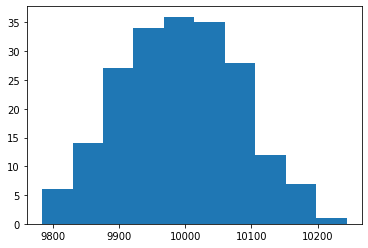

In [71]:
plt.hist(start_neighbor_distances)

(array([ 2.,  1., 14., 24., 35., 57., 27., 24., 13.,  3.]),
 array([ 9745.3152557 ,  9786.44640246,  9827.57754922,  9868.70869598,
         9909.83984275,  9950.97098951,  9992.10213627, 10033.23328303,
        10074.36442979, 10115.49557655, 10156.62672331]),
 <BarContainer object of 10 artists>)

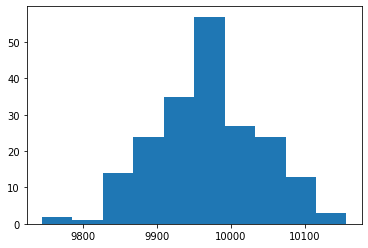

In [72]:
plt.hist(adv_neighbor_distances)

In [73]:
np.mean(adv_neighbor_distances)

9968.880871738756

In [74]:
np.mean(start_neighbor_distances)

9993.585009765626

In [75]:
np.std(adv_neighbor_distances)

74.24857643062266

In [77]:
np.std(start_neighbor_distances)

87.18667565876925

In [80]:
# with open('info_iters.p','rb') as F:
#     all_info = pickle.load(F)

# Adversarial Training analysis

### Collect adv points (25% of training data size)

In [85]:
attack_output_2 = {}

In [101]:
attack_output_2[dsize] = cma_experiment(model_to_attack, 4000)

dset_size_10000


  0%|          | 0/4000 [00:00<?, ?it/s]

In [107]:
# with open('inof.p', 'wb') as F:
#     pickle.dump(attack_output_2, F)

In [131]:
augmented_training_data = torch.vstack([training_points, torch.tensor(attack_output_2[dsize].in_dist_advs).float().cuda()])

### Train with them

In [132]:
training_labels = dset[2]

In [133]:
augmented_training_labels = torch.hstack([training_labels, torch.zeros(4000).long().cuda()])

In [134]:
# augmented_training_labels[-1]

In [135]:
dset_new = [augmented_training_data, dset[1], augmented_training_labels, dset[3]] 

In [136]:
adv_trained_models = {}

In [144]:
adv_attack_output = {}

In [137]:
# dset = make_dataset(dsize)
adv_trained_models[dsize] = train_model(N_dim, dset_new, 'dset_size_%s_adv'%dsize)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:999, Train Acc:tensor(1., device='cuda:0')
Epoch:999, Test Acc:tensor(1., device='cuda:0')


In [143]:
# adv_trained_models[10000].dataset[0].shape

In [145]:
adv_model_to_attack = adv_trained_models[dsize].cpu()
adv_attack_output[dsize] = cma_experiment(adv_model_to_attack, 50)

dset_size_10000_adv


  0%|          | 0/50 [00:00<?, ?it/s]

In [147]:
# len(adv_attack_output[dsize].in_dist_advs)

# Training Image Models

In [189]:
# dset = make_dataset(dsize, image_data=True)

In [190]:
# sample_uniform(100, N_dim, x1_min, x1_max, True)

In [192]:
dset[0].shape

torch.Size([16000, 3, 15, 15])

In [257]:
# all_info = []

# for iteration in range(10):
#     print('*'*50)
#     print('Iteration %s'%iteration)
#     print('*'*50)
    
#     trained_models = {}
#     attack_output = {}
#     for dsize in [10000]:
#         print('Working with with %s'%dsize)
#         dset = make_dataset(dsize, image_data=True)
#         trained_models[dsize] = train_model(N_dim, dset, 'dset_size_%s'%dsize, image_data=True)
#         model_to_attack = trained_models[dsize].cpu()
#         attack_output[dsize] = cma_experiment(model_to_attack, 10, image_data=True)
#     iter_info = [trained_models, attack_output]
#     all_info.append(iter_info)

In [205]:
# with open('all_info_lenet.p','wb') as F:
#     pickle.dump(all_info, F)

# Train ResNet

In [ ]:
import torch
import torchvision

resnet_model = torchvision.models.resnet18(num_classes = 2)

In [206]:
dset = make_dataset(dsize, image_data=True)

# trained_models[dsize] = train_model(N_dim, dset, 'dset_size_%s'%dsize, image_data=True)
# model_to_attack = trained_models[dsize].cpu()
# attack_output[dsize] = cma_experiment(model_to_attack, 10, image_data=True)
# iter_info = [trained_models, attack_output]
# all_info.append(iter_info)

In [231]:
resnet_model = torchvision.models.resnet18(num_classes = 2).cuda()

In [216]:
batch_size = 400

In [219]:
resnet_dataset = {}
resnet_dataset['train'] = dset[0]
resnet_dataset['test'] = dset[1]

resnet_labels= {}
resnet_labels['train'] = dset[2]
resnet_labels['test'] = dset[3]

In [228]:
# X.shape[0]

In [238]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.0001)

In [250]:
for epoch in tqdm(range(100)):
    for phase in ['train', 'test']:
        X = resnet_dataset[phase]
        Y = resnet_labels[phase]
        iters = int(X.shape[0]/batch_size)
        batch_corrects = 0
        for i in range(iters):
            batch_data = X[batch_size*i:batch_size*(i+1)].float()            
            batch_labels = Y[batch_size*i:batch_size*(i+1)].long()
            
            optimizer.zero_grad()
            outputs = resnet_model(batch_data)           
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            iter_corrects = torch.sum(torch.argmax(outputs, dim = 1) == batch_labels).item()
            batch_corrects += iter_corrects
        if epoch % 5 == 0:
            print('%s accuracy: %s'%(phase, batch_corrects/len(X)))

  0%|          | 0/100 [00:00<?, ?it/s]

train accuracy: 0.91625
test accuracy: 0.95775
train accuracy: 0.9983125
test accuracy: 1.0
train accuracy: 0.99975
test accuracy: 1.0
train accuracy: 1.0
test accuracy: 1.0
train accuracy: 1.0


KeyboardInterrupt: 

In [251]:
torch.save(resnet_model, 'resnet_uniform_data_20_epoch.pt')

In [252]:
resnet_model_to_attack = resnet_model.cpu()

In [253]:
resnet_attack_output = {}

In [283]:
start_pos[0].shape

torch.Size([3, 15, 15])

In [284]:
start_pos[0].reshape(1,-1)[0].shape

torch.Size([675])

In [291]:
# torch.sum(start_pos[0].reshape(1,-1)[0].reshape(3,15,15) == start_pos[0])

In [270]:
# initial_pred

0

In [310]:
CURRENT_MODEL = CURRENT_MODEL.cuda()

In [ ]:
resnet_attack_output[dsize] = cma_experiment(resnet_model_to_attack, 50, image_data=True)

ResNet


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
with open('resnet_attack_output.p', 'wb') as F:
    pickle.dump(resnet_attack_output, F)

# Aggregate evaluation

In [163]:
all_distances = {}
in_dists = {}

In [164]:
# all_info[0][1][dsize].in_dist_advs

In [165]:
for dsize in [1000, 100000]:
    all_distances[dsize] = []
    in_dists[dsize] = []
    for i in range(1):
        in_dists[dsize].append(len(all_info[i][1][dsize].in_dist_advs))
        all_distances[dsize].append(np.nanmean(all_info[i][1][dsize].distances))

In [166]:
# all_distances.keys()

In [167]:
for key in all_distances.keys():
    print(np.nanmean(all_distances[key]))

3.2171293443927995
5.13962748088732


In [168]:
for key in in_dists.keys():
    print(np.mean(in_dists[key]))

10.0
10.0


In [169]:
def predict(model, point):
    prepped_point = torch.from_numpy(point).cuda().float().unsqueeze(0)
    prediction = torch.argmax(model(prepped_point)[0]).item()
    return prediction

# Visualization

In [170]:
# dset = make_dataset(1000)

In [171]:
# _, X_test, _, Y_test = dset

In [172]:
# from mlxtend.plotting import plot_decision_regions

In [173]:
# torch.save(all_info[0][0][1000],'test_model.pt')

In [174]:
# !pip install pytorch2keras

In [175]:
# import onnx
# a# from keras.models import load_model

# pytorch_model = 'test_model.pt'
# keras_output = 'test_model_keras.hd5'
# onnx.convert(pytorch_model, keras_output)
# # 
# # preds = model.predict(x)

In [176]:
# keras_model = load_model(keras_output)

In [129]:
# value=1.5
# width=0.75
# features_to_plot = [0,1]
# filler_values = {}
# filler_ranges = {}
# for i in range(N_dim):
#     if i not in features_to_plot:
#         filler_values[i] = value
#         filler_ranges[i] = width


# plot_decision_regions(X_test.cpu().numpy(), Y_test.cpu().numpy().astype('int'), 
#                       clf=all_info[0][0][1000], legend = 2, feature_index=[0,1],                        #these one will be plotted  
#                   filler_feature_values=filler_values,  #these will be ignored
#                   filler_feature_ranges=filler_ranges)

# Sensitivity Analysis

In [190]:
DSIZE = 1000

In [191]:
mod = all_info[0][0][DSIZE].cuda()

In [192]:
def min_subset(start, adv, mod, start_id = 0):
    for i in range(start_id, start_id + 50):
        index = i%50
        start[:index] = adv[:index]
        start_pred = predict(mod, start)
        adv_pred = predict(mod, adv)
        if start_pred == adv_pred:
            break
    return index        
#     print('Broke at %i'%index)

In [193]:
broken_changes = []
for i in range(10):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    broken_change = min_subset(start_point, adv_point, mod, random.choice(list(range(50))))
    broken_changes.append(broken_change)

In [194]:
print(np.mean(broken_changes))
print(np.std(broken_changes))

44.1
6.057227088363123


# Opposite change

In [137]:
with open('info_iters.p','rb') as F:
    all_info = pickle.load(F)

In [138]:
def min_subset_reform(start, adv, mod, start_id = 0):
    for i in range(start_id, start_id + 50):
        index = i%50
        adv[:index] = start[:index]
        start_pred = predict(mod, start)
        adv_pred = predict(mod, adv)
        if start_pred == adv_pred:
            break
    return index

In [139]:
broken_changes = []
for i in range(50):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    broken_change = min_subset_reform(start_point, adv_point, mod, random.choice(list(range(50))))
    broken_changes.append(broken_change)

In [530]:
print(np.mean(broken_changes))
print(np.std(broken_changes))

24.18
13.122027282398097


# Random Perturb

In [532]:
with open('info_iters.p','rb') as F:
    all_info = pickle.load(F)

In [533]:
def min_subset_random(start, adv, mod, start_id = 0):
    for i in range(start_id, start_id + 50):
        index = i%50
        start[index] = np.random.normal(loc=np.mean(start[index]),scale=np.std(start[index]))
        start_pred = predict(mod, start)
        adv_pred = predict(mod, adv)
        if start_pred == adv_pred:
            break
    return index

In [534]:
broken_changes = []
for i in range(50):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    broken_change = min_subset_random(start_point, adv_point, mod, random.choice(list(range(50))))
    broken_changes.append(broken_change)

In [536]:
print(np.mean(broken_changes))
print(np.std(broken_changes))

28.98
12.657788116412757


# Church Window Plots

In [21]:
def perpendicular_vector(v):
    random_vector = np.random.randn(N_dim)
    orthogonal = random_vector - random_vector.dot(v)*v/np.linalg.norm(v)**2
    orthogonal_normalized = orthogonal/np.linalg.norm(orthogonal) * np.linalg.norm(v)
    return orthogonal_normalized

def plot_church_window(start_point, adv_point):
    adv_vector = adv_point - start_point
#     adv_vector = np.random.randn(N_dim)*2.5
    orthogonal_vector = perpendicular_vector(adv_vector)


    ##### Collect Predictions ######
    predictions = np.zeros((40,40))

    row_num = 0
    col_num = 0

    for alpha in np.arange(0, 2.0, 0.05):
        for beta in np.arange(0, 2.0, 0.05):
            curr_point = start_point + beta*adv_vector + alpha*orthogonal_vector
            curr_pred = predict(model, curr_point)
            predictions[row_num][col_num] = curr_pred
            col_num += 1
        row_num += 1
        col_num = 0

    ##### Plot ######
    plt.imshow(predictions, cmap=custom_cmap)
    plt.xlim([0, 40])
    plt.ylim([0, 40])
    plt.title('Church Window Plot')
    plt.xticks(range(0,40,5), labels = np.arange(0,2,0.25))
    plt.yticks(range(0,40,5), labels = np.arange(0,2,0.25))
    plt.xlabel('Adversarial Direction')
    plt.ylabel('Orthogonal Direction')
    plt.show()

In [22]:
DSIZE = 1000
N_dim = 1024

In [23]:
with open('info_iters.p','rb') as F:
    all_info = pickle.load(F)

In [24]:
# len(all_info[0][1][DSIZE].in_dist_advs)

In [25]:
# predictions

In [26]:
from matplotlib import colors

custom_cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, custom_cmap.N)

In [27]:
model = all_info[0][0][DSIZE].cuda()

for i in range(10):
    adv_point = all_info[0][1][DSIZE].in_dist_advs[i]
    start_point = all_info[0][1][DSIZE].starts[i]
    start_point = np.array(start_point)[0]
    plot_church_window(start_point, adv_point)

ValueError: shapes (1024,) and (50,) not aligned: 1024 (dim 0) != 50 (dim 0)